In [730]:
import pywt
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Model Implementation

### Layers

In [731]:
class dwt:
    def __init__(self, filter_size, h = None, g = None):
        if h is None:
            self.h = np.random.normal(1,2,filter_size)
        else:
            self.h = h
        
        if g is None:
            self.g = np.random.normal(1,2,filter_size)
        else:
            self.g = g
        
    def compute(self, input_):
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.dwt(input_, wavelet=my_wavelet)
    
    def inverse(self):
        return idwt(self)
    
    def update_weigths(self, hg, gg, lr = 0.001):
        self.h = self.h - lr*hg
        self.g = self.g - lr*gg

In [732]:
class idwt:
    def __init__(self, dwt):
        self.h = dwt.h
        self.g = dwt.g
    
    def compute(self, input_):
        ca,cd = input_
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.idwt(ca,cd, wavelet=my_wavelet)

### Loss function

In [733]:
def loss_function(h, g, x, x_, W, reconstruction_weight = 1):
    l1 = 0.5
    l2 = 0.5
    r1 = reconstruction_weight
    s1 = mean_squared_error(x, x_)
    s2 = np.sum(np.abs(W))
    s3 = lhg(h,g)
    return r1*s1 + l1*s2 + l1*s3
    
def lhg(h, g):
    s1 = (np.sum(h**2) - 1)**2
    s2 = (np.sum(h) - math.sqrt(2))**2
    s3 = np.sum(g)**2
    return s1 + s2 + s3

### Gradient Computation

In [734]:
def compute_gradient_h(h, g, x, loss_function, diff = 0.001):
    length = len(h)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        h_plus = h + mask
        h_minus = h - mask
        
        dwtp = dwt(1, h_plus, g)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h_minus, g)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h_plus, g, x, x_p, Wp)
        lossm = loss_function(h_minus, g, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient_g(h, g, x, loss_function, diff = 0.001):
    length = len(g)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        g_plus = g + mask
        g_minus = g - mask
        
        dwtp = dwt(1, h, g_plus)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h, g_minus)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h, g_plus, x, x_p, Wp)
        lossm = loss_function(h, g_minus, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient(h, g, x, loss_function, diff = 0.001):
    hg = compute_gradient_h(h, g, x, loss_function, diff)
    gg = compute_gradient_g(h, g, x, loss_function, diff)
    return (hg, gg)
    
    
    

### Model Class

In [735]:
class Model:
    def __init__(self,filter_size = 2**5):
        self.my_dwt = dwt(filter_size)
        self.my_idwt = self.my_dwt.inverse()
        self.losses = []
        self.min_loss = math.inf
        
    def fit(self, x, epochs = 100, learning_rate = 0.001, verbose = True, good_error = None, reconstruction_weight = 1, diff = 0.000001):
        best_h = self.my_dwt.h
        best_g = self.my_idwt.g
        for i in range(epochs):
            W = self.my_dwt.compute(x)
            x_ = self.my_idwt.compute(W)
            loss = loss_function(self.my_dwt.h, self.my_dwt.g, x, x_, W, reconstruction_weight)
            self.losses.append(loss)
            if loss < self.min_loss:
                self.min_loss = loss
                best_h = self.my_dwt.h
                best_g = self.my_dwt.g
            
            if verbose:
                print('Epochs #' + str(i+1) + ": " + str(loss) + " loss")
            
            if not good_error is None and loss <= good_error:
                return
            
            hg, gg = compute_gradient(self.my_dwt.h, self.my_dwt.g, x, loss_function, diff)
            self.my_dwt.update_weigths(hg, gg, learning_rate)
        
        self.my_dwt = dwt(1, best_h, best_g)
        self.my_idwt = self.my_dwt.inverse()
        print("Best Loss", self.min_loss)
    
    def predict(self, x):
        W = self.my_dwt.compute(x)
        return self.my_idwt.compute(W)
    
    def wavelet(self):
        filter_bank = [self.my_dwt.h, self.my_dwt.g, np.flip(self.my_dwt.h), np.flip(self.my_dwt.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return my_wavelet
    
    def dwt(self, x):
        ca, cd = self.my_dwt.compute(x)
        return np.concatenate([cd, ca])
    
        
            

# Testing

### Signal generation functions

In [736]:
def generate_wave_coeff(length):
    result = []
    for _ in range(length*2):
        if np.random.random() < 0.9:
            result.append(0.0)
        else:
            result.append(np.random.uniform(-1,1))
    
    return (result[:length], result[length:])


def generate_signal(length, familie):    
    ca, cd = generate_wave_coeff(length)
    x = pywt.idwt(ca, cd, familie)
    return x


### Distance between filters

In [753]:
def dist(f1, f2):
    max_l = max(len(f1), len(f2))
    min_l = min(len(f1), len(f2))
    diff = max_l - min_l
    best_i = 0
    
    if len(f1) == min_l:
        f1 = np.concatenate([f1, np.zeros(diff)])
        
    if len(f2) == min_l:
        f2 = np.concatenate([f2, np.zeros(diff)])
    
    distance = math.inf
    f1_norm2 = np.sqrt(np.sum(f1**2))
    f2_norm2 = np.sqrt(np.sum(f2**2))
    for i in range(max_l):
        current = 1 - (f1.dot(np.roll(f2,i))/(f1_norm2 * f2_norm2))
        if current < distance:
            distance = current
            best_i = i
    
    f2 = np.roll(f2, best_i)
    return distance

### Currently the built-in families are:

   - Haar (haar)
   - Daubechies (db)
   - Symlets (sym)
   - Coiflets (coif)
   - Biorthogonal (bior)
   - Reverse biorthogonal (rbio)
   - “Discrete” FIR approximation of Meyer wavelet (dmey)
   - Gaussian wavelets (gaus)
   - Mexican hat wavelet (mexh)
   - Morlet wavelet (morl)
   - Complex Gaussian wavelets (cgau)
   - Shannon wavelets (shan)
   - Frequency B-Spline wavelets (fbsp)
   - Complex Morlet wavelets (cmor)


### Print wavelets for a familie

In [757]:
print(pywt.wavelist('sym'))

['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


### Select a orthogonal wavelet for testing

In [769]:
w = 'sym4'
wavelet = pywt.Wavelet(w)
print("is orthogonal?",wavelet.orthogonal)
wavelet.dec_len

is orthogonal? True


8

### Signal generation and fiting

In [770]:
x = generate_signal(32, w)

In [771]:

model = Model(6)

In [772]:
model.fit(x, epochs=2000, learning_rate=0.001, good_error=1, reconstruction_weight=10)

Epochs #1: 317.3296609413245 loss
Epochs #2: 252.78191710963986 loss
Epochs #3: 218.25697307283727 loss
Epochs #4: 195.99816706396007 loss
Epochs #5: 180.26230359911867 loss
Epochs #6: 168.278631912333 loss
Epochs #7: 158.67265958486306 loss
Epochs #8: 150.7138667185215 loss
Epochs #9: 143.95295387474727 loss
Epochs #10: 138.09881590411018 loss
Epochs #11: 132.9554159242766 loss
Epochs #12: 128.37599340289984 loss
Epochs #13: 124.25817811322855 loss
Epochs #14: 120.52516868930198 loss
Epochs #15: 117.11794191149713 loss
Epochs #16: 113.99015894005328 loss
Epochs #17: 111.10474315018214 loss
Epochs #18: 108.43152563522717 loss
Epochs #19: 105.94559036105353 loss
Epochs #20: 103.62608817017914 loss
Epochs #21: 101.45551626324391 loss
Epochs #22: 99.42361433002142 loss
Epochs #23: 97.51199749175339 loss
Epochs #24: 95.70938692238772 loss
Epochs #25: 94.00913310720495 loss
Epochs #26: 92.42468890936534 loss
Epochs #27: 90.92112783449632 loss
Epochs #28: 89.49182403915499 loss
Epochs #29: 8

Epochs #234: 31.670279772664642 loss
Epochs #235: 31.609624916015754 loss
Epochs #236: 31.563205605959183 loss
Epochs #237: 31.457863636094746 loss
Epochs #238: 31.3459783094367 loss
Epochs #239: 31.296386983373964 loss
Epochs #240: 31.185890028389537 loss
Epochs #241: 31.08635550833477 loss
Epochs #242: 31.030800801296838 loss
Epochs #243: 30.931687794476517 loss
Epochs #244: 30.835218889104908 loss
Epochs #245: 30.77773143187089 loss
Epochs #246: 30.67750203622674 loss
Epochs #247: 30.62967155622832 loss
Epochs #248: 30.521909444465678 loss
Epochs #249: 30.424560079269792 loss
Epochs #250: 30.371002271125022 loss
Epochs #251: 30.274247392406092 loss
Epochs #252: 30.17939585864201 loss
Epochs #253: 30.127736836980066 loss
Epochs #254: 30.033208226998152 loss
Epochs #255: 29.9405589979501 loss
Epochs #256: 29.890695437907972 loss
Epochs #257: 29.798263439221852 loss
Epochs #258: 29.70055033304163 loss
Epochs #259: 29.660030581347854 loss
Epochs #260: 29.569535950375414 loss
Epochs #261

Epochs #473: 18.769031865369435 loss
Epochs #474: 18.72424934628077 loss
Epochs #475: 18.72214581443425 loss
Epochs #476: 18.681434314790756 loss
Epochs #477: 18.635101681105052 loss
Epochs #478: 18.595302236233962 loss
Epochs #479: 18.550413474808856 loss
Epochs #480: 18.54880041120535 loss
Epochs #481: 18.508257421903565 loss
Epochs #482: 18.462257806422738 loss
Epochs #483: 18.42264058965035 loss
Epochs #484: 18.37773228726892 loss
Epochs #485: 18.3766000588953 loss
Epochs #486: 18.33626070073526 loss
Epochs #487: 18.290633157082464 loss
Epochs #488: 18.251249705170732 loss
Epochs #489: 18.21236837509777 loss
Epochs #490: 18.167691313626833 loss
Epochs #491: 18.129658305662183 loss
Epochs #492: 18.123236889683152 loss
Epochs #493: 18.084020403575064 loss
Epochs #494: 18.04523835783178 loss
Epochs #495: 18.00084181446361 loss
Epochs #496: 17.962908750954202 loss
Epochs #497: 17.92018626039851 loss
Epochs #498: 17.91935304885552 loss
Epochs #499: 17.880628568671455 loss
Epochs #500: 1

Epochs #710: 12.26719068269034 loss
Epochs #711: 12.271107595499194 loss
Epochs #712: 12.242520301941017 loss
Epochs #713: 12.214551058868821 loss
Epochs #714: 12.184124799526487 loss
Epochs #715: 12.188156213778907 loss
Epochs #716: 12.160329945584454 loss
Epochs #717: 12.133456913398343 loss
Epochs #718: 12.13213688623846 loss
Epochs #719: 12.10643325344858 loss
Epochs #720: 12.079324014006303 loss
Epochs #721: 12.053511910767835 loss
Epochs #722: 12.05711605400412 loss
Epochs #723: 12.030158228885602 loss
Epochs #724: 11.999717446493547 loss
Epochs #725: 12.004968565238928 loss
Epochs #726: 11.977921379185597 loss
Epochs #727: 11.951568806711913 loss
Epochs #728: 11.92200783406434 loss
Epochs #729: 11.927406723330348 loss
Epochs #730: 11.900914818959839 loss
Epochs #731: 11.875069974254197 loss
Epochs #732: 11.846476859739637 loss
Epochs #733: 11.8700977593902 loss
Epochs #734: 11.843472338172267 loss
Epochs #735: 11.847585037324594 loss
Epochs #736: 11.822257901999132 loss
Epochs #

Epochs #948: 8.712482738230413 loss
Epochs #949: 8.700177148586922 loss
Epochs #950: 8.685946858608105 loss
Epochs #951: 8.671824514506934 loss
Epochs #952: 8.655668057442393 loss
Epochs #953: 8.667780762544758 loss
Epochs #954: 8.652714701738285 loss
Epochs #955: 8.637790721911085 loss
Epochs #956: 8.623293977886629 loss
Epochs #957: 8.630482532999451 loss
Epochs #958: 8.616493929074771 loss
Epochs #959: 8.600914607023178 loss
Epochs #960: 8.585501329543728 loss
Epochs #961: 8.570933808231617 loss
Epochs #962: 8.578703621584307 loss
Epochs #963: 8.562543303214484 loss
Epochs #964: 8.546614195087074 loss
Epochs #965: 8.532734795196603 loss
Epochs #966: 8.513932352611514 loss
Epochs #967: 8.523102569789852 loss
Epochs #968: 8.50852454231365 loss
Epochs #969: 8.49197545114479 loss
Epochs #970: 8.475756365998539 loss
Epochs #971: 8.457065837534238 loss
Epochs #972: 8.467455383155723 loss
Epochs #973: 8.450492503277037 loss
Epochs #974: 8.433767242200378 loss
Epochs #975: 8.417511841360138

Epochs #1173: 6.2045312687523095 loss
Epochs #1174: 6.207448541486119 loss
Epochs #1175: 6.19279770152596 loss
Epochs #1176: 6.183648245132508 loss
Epochs #1177: 6.167541630514207 loss
Epochs #1178: 6.17450130372173 loss
Epochs #1179: 6.159932025909245 loss
Epochs #1180: 6.138885780810762 loss
Epochs #1181: 6.130362853027205 loss
Epochs #1182: 6.137470850354179 loss
Epochs #1183: 6.122631082815354 loss
Epochs #1184: 6.10592349339905 loss
Epochs #1185: 6.085765431641882 loss
Epochs #1186: 6.102451129558922 loss
Epochs #1187: 6.085233660505716 loss
Epochs #1188: 6.068403685911673 loss
Epochs #1189: 6.052135013491203 loss
Epochs #1190: 6.040497835940599 loss
Epochs #1191: 6.048913032288731 loss
Epochs #1192: 6.032073802718321 loss
Epochs #1193: 6.015605100934727 loss
Epochs #1194: 5.999834378424656 loss
Epochs #1195: 6.012517946690644 loss
Epochs #1196: 5.99568723803131 loss
Epochs #1197: 5.9792911166058 loss
Epochs #1198: 5.965422854111219 loss
Epochs #1199: 5.946357221259863 loss
Epochs

Epochs #1397: 4.404993532832366 loss
Epochs #1398: 4.393208306988588 loss
Epochs #1399: 4.402955864532048 loss
Epochs #1400: 4.392342827040686 loss
Epochs #1401: 4.37971822970759 loss
Epochs #1402: 4.388091803709013 loss
Epochs #1403: 4.380970296489328 loss
Epochs #1404: 4.367897929896491 loss
Epochs #1405: 4.3525959834539805 loss
Epochs #1406: 4.362208603046791 loss
Epochs #1407: 4.349201334953178 loss
Epochs #1408: 4.342737753062212 loss
Epochs #1409: 4.351119584537493 loss
Epochs #1410: 4.33786657490175 loss
Epochs #1411: 4.323092695393842 loss
Epochs #1412: 4.317444782272248 loss
Epochs #1413: 4.325408990546916 loss
Epochs #1414: 4.314859887793581 loss
Epochs #1415: 4.301958094004215 loss
Epochs #1416: 4.2863736996311115 loss
Epochs #1417: 4.300164247894395 loss
Epochs #1418: 4.289761444160375 loss
Epochs #1419: 4.277031154317728 loss
Epochs #1420: 4.285705086604274 loss
Epochs #1421: 4.2765845958810615 loss
Epochs #1422: 4.263895836429232 loss
Epochs #1423: 4.248608122873333 loss


Epochs #1622: 3.0992736799690683 loss
Epochs #1623: 3.092989333954144 loss
Epochs #1624: 3.085449821689526 loss
Epochs #1625: 3.0996379477021083 loss
Epochs #1626: 3.0889220315709003 loss
Epochs #1627: 3.0866171278942014 loss
Epochs #1628: 3.077550712305386 loss
Epochs #1629: 3.066107862894079 loss
Epochs #1630: 3.0608171068572645 loss
Epochs #1631: 3.060373602867426 loss
Epochs #1632: 3.051889040025628 loss
Epochs #1633: 3.062758946429857 loss
Epochs #1634: 3.0538498503281293 loss
Epochs #1635: 3.0446565741805167 loss
Epochs #1636: 3.0384574647998948 loss
Epochs #1637: 3.037631860350333 loss
Epochs #1638: 3.0313976618907112 loss
Epochs #1639: 3.0362522476055394 loss
Epochs #1640: 3.02710410836496 loss
Epochs #1641: 3.025136372989919 loss
Epochs #1642: 3.014928458748466 loss
Epochs #1643: 3.0121620375390736 loss
Epochs #1644: 3.005027684488409 loss
Epochs #1645: 2.9979603514549624 loss
Epochs #1646: 3.0146110688510217 loss
Epochs #1647: 3.005716332274389 loss
Epochs #1648: 2.9927934440

Epochs #1845: 2.264639156650181 loss
Epochs #1846: 2.2584907213632412 loss
Epochs #1847: 2.263180253581746 loss
Epochs #1848: 2.2590325631042085 loss
Epochs #1849: 2.251020349385604 loss
Epochs #1850: 2.245113859884517 loss
Epochs #1851: 2.2525586498274572 loss
Epochs #1852: 2.251105866856163 loss
Epochs #1853: 2.244313927283536 loss
Epochs #1854: 2.2371648707095093 loss
Epochs #1855: 2.2308840217565535 loss
Epochs #1856: 2.232660268330515 loss
Epochs #1857: 2.2264585495578073 loss
Epochs #1858: 2.2327001480087922 loss
Epochs #1859: 2.228066224648528 loss
Epochs #1860: 2.222646135764306 loss
Epochs #1861: 2.2157176310624185 loss
Epochs #1862: 2.2071802776691642 loss
Epochs #1863: 2.2048662027123327 loss
Epochs #1864: 2.1995619268849422 loss
Epochs #1865: 2.2046179448890344 loss
Epochs #1866: 2.2033045776305116 loss
Epochs #1867: 2.196125311542821 loss
Epochs #1868: 2.1885501230545947 loss
Epochs #1869: 2.184394462927165 loss
Epochs #1870: 2.196458510239213 loss
Epochs #1871: 2.19035693

## Metrics and plot

 ### Reconstruction Error

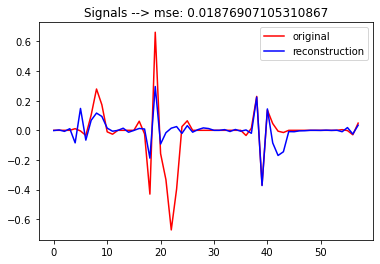

In [773]:
p = model.predict(x)
mse = mean_squared_error(p,x)

plt.plot(np.arange(len(x)), x, c = 'r', label="original")
plt.plot(np.arange(len(p)), p, c = 'b', label="reconstruction")
plt.legend()
plt.title("Signals -->" + " mse: " + str(mse))
print()

### Wavelets and Scaling functions error

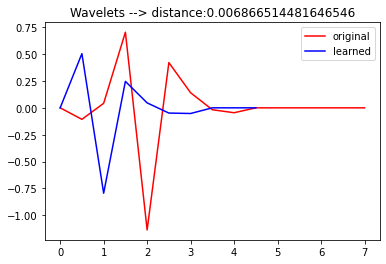

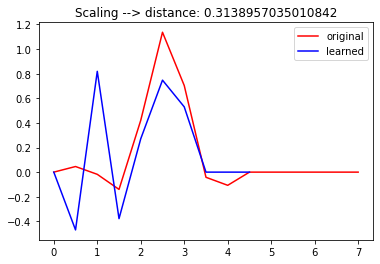

In [774]:
[phi_d,psi_d,phi_r,psi_r,al] = model.wavelet().wavefun(level=1)
[phi, psi, ao] = pywt.Wavelet(w).wavefun(level=1)
lo = np.arange(len(ao))
plt.figure(1)
plt.plot(ao, psi, c = 'r', label="original")
plt.plot(al,psi_d, c='b', label='learned')
plt.title("Wavelets --> distance:" + str(dist(psi, psi_d)))
plt.legend()

plt.figure(2)
plt.title("Scaling --> distance: " +  str(dist(phi, phi_d)))
plt.plot(ao, phi, c = 'r', label="original")
plt.plot(al,phi_d, c='b', label='learned')
plt.legend()


print()

### DWT error

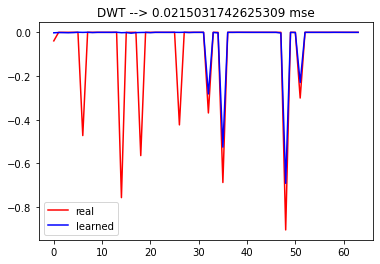

In [768]:

fake_dwt = model.dwt(x)
ca, cd = pywt.dwt(x, wavelet=w)
real_dwt = np.concatenate([cd, ca])

fake_len = len(fake_dwt)
real_len = len(real_dwt)

min_len = min(fake_len, real_len)
real_dwt = real_dwt[:min_len]
fake_dwt = fake_dwt[:min_len]

mse_dwt = mean_squared_error(real_dwt, fake_dwt)
plt.plot(np.arange(min_len), real_dwt, c = 'r', label = 'real')
plt.plot(np.arange(min_len), fake_dwt, c = 'b', label = 'learned')
plt.title("DWT --> " + str(mse_dwt) + " mse")
plt.legend()
print()